import everything

In [1]:
from datetime import datetime
import pandas as pd
from scipy.stats import loguniform 
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
import pandas as pd
from calcDrop_v2 import corrX_new
import numpy as np
from sklearn.inspection import permutation_importance as pfi
from mrmr import mrmr_classif
import pickle
from sklearn.metrics import accuracy_score, roc_auc_score, balanced_accuracy_score
from sklearn.model_selection import RepeatedStratifiedKFold, RandomizedSearchCV, GroupShuffleSplit, cross_validate
from split_new import RepeatedStratifiedGroupKFold
# from sklearn.model_selection import RepeatedStratifiedGroupKFold
from imblearn.metrics import specificity_score
from sklearn.metrics import make_scorer
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA

ceate dataset

In [2]:
df = pd.read_excel(r'D:\code备份\7.29\Hesheng Gong - code\feature_map_729.xlsx')
pnam = df['Patient name ' ]
X = df.drop(['Slice no. ', 'Label', 'Patient name '], axis=1)
y = df['Label']

read the feature map with 181 features.

get:

pnam -> patient ID

X -> map with just feature names

y -> class patients for their aggressive tumor or not

Remove highly correlated features

In [3]:
to_drop = corrX_new(X, y, cut = 0.9)
X = X.drop(to_drop, axis=1)
df = df.drop(to_drop, axis=1)
print("Number of features left after dropping highly correlated features: ", np.shape(X)[1])

Number of features left after dropping highly correlated features:  77


In [4]:
# 获取 X 中剩余的特征名称列表
remaining_features_X = X.columns.tolist()

# 获取 df 中剩余的特征名称列表
remaining_features_df = df.columns.tolist()

# 将 X 中的剩余特征名称写入文本文件
with open('remaining_features_X.txt', 'w') as file:
    for feature in remaining_features_X:
        file.write(feature + '\n')

# 将 df 中的剩余特征名称写入文本文件
with open('remaining_features_df.txt', 'w') as file:
    for feature in remaining_features_df:
        file.write(feature + '\n')

print("Feature names have been saved to 'remaining_features_X.txt' and 'remaining_features_df.txt'")



Feature names have been saved to 'remaining_features_X.txt' and 'remaining_features_df.txt'


do correlation analysis to X and drop those high correlation features(cut = 0.9) & do the same thing to the df frame

store the selected features in the .txt file (keep X and df respectively in case differences exist)

Apply PCA to find number of relevant features

In [5]:
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
pca = PCA(.95).fit(X_scaled)
print("Number of components left after PCA: ", pca.n_components_)
features_PCA = pca.transform(X_scaled)

Number of components left after PCA:  18


create a class for data normalization, averge as 0 and std as 1 (Standard Normal Distribution)

fit X in it and normalize X to calculate feature matrix X_scaled

implement PCA with 95% variance

apply MRMR

In [6]:
# X = df.drop(['Slice no. ', 'Label', 'Patient name '], axis =1)
selected_features = mrmr_classif(X=X, y=y, K=pca.n_components_)
X = X[selected_features]
featNames = X.columns

100%|██████████| 18/18 [00:00<00:00, 28.66it/s]


In [7]:
for name in featNames:
    print(name)

# 将PCA成分名称保存到文本文件
with open('featNames.txt', 'w') as file:
    for name in featNames:
        file.write(name + '\n')

print("PCA feature names have been saved to 'featNames.txt'")

DCEpeak.Global.Kurtosis
T2.Global.Variance
ADC.GLSZM.ZP
MRDI.kep
ADC.grayscale_raw
DCEwashin.GLCM.AutoCorrelation
DCEpeak.GLSZM.LZLGE
ADC.Global.Variance
DCEpeak.GLSZM.HGZE
DCEwashin.GLSZM.SZLGE
DCEwashin.GLSZM.GLN
T2.GLRLM.GLN
DCEwashin.Global.Skewness
T2.GLCM.AutoCorrelation
DCEwashin.Global.Kurtosis
DCEwashin.GLCM.Variance
T2.GLSZM.SZE
DCEpeak.GLRLM.LGRE
PCA feature names have been saved to 'featNames.txt'


implement MRMR to the features to select the ones that are highly correlated with the target variable y but with minimal redundancy. keep the most important features after MRMR in featNames.

K the same as pca.n_components_: keep the same feature dimension

read the file directly

In [88]:
now = datetime.now()
dt_string = now.strftime("%d_%m_%Y__%H_%M_%S")
print(dt_string)

03_08_2024__16_59_34


running time recording

model settings

In [8]:
from sklearn.metrics import make_scorer, roc_auc_score, accuracy_score, balanced_accuracy_score, recall_score

models = ["kNN","SVM","LR"]

cv_outer = RepeatedStratifiedGroupKFold(n_splits=5, n_repeats=1, random_state=42)


multi_scorings = {"AUC": "roc_auc", "ACC": "accuracy", "bACC" :'balanced_accuracy', 
                  "SENS": "recall", "SPEC": make_scorer(specificity_score)}

scoring_metrics=['AUC','bACC', 'ACC', 'SENS', 'SPEC']

define model types, 5 fold cross-validation and evaluation scores

8.3 version

In [9]:
plot_data = {model_name: {'n_features': [], 'mean_auc': [], 'std_auc': []} for model_name in models}

In [57]:
# Initialize variables
final_results = []
training_metrics = []
test_metrics = []
training_metrics_all = []
test_metrics_all = []

groups = pnam.values

test_save_x = []
test_save_y = []
test_save_pnam = []
test_save_index = []


# 5-fold cross-validation
for train_idx, test_idx in cv_outer.split(X, y, groups):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    pnam_train, pnam_test = pnam[train_idx], pnam[test_idx]
    test_save_x = [test_save_x, X_test]
    test_save_y = [test_save_y, y_test]
    test_save_pnam = [test_save_pnam, pnam_test]
    test_save_index = [test_save_index, test_idx]

    model_results = {}
    aggregated_importance = {model_name: np.zeros(X.shape[1]) for model_name in models}

    # for scoring_metric in scoring_metrics:
    for model_name in models:
        pfis = []
    
        final_dict, final_dict_avg = {}, {}
        result_outer = list()
        features_number, grid_score, grid_parms = [], [], []
        n_features_list, result_outer_mean, result_outer_std = [], [], []
        df_res_cv = pd.DataFrame()
        rankings, selecfeat_names = [], []
        best_models = []
        best_aucs = []
        n_features_list = []

        if model_name == "LR":
            print("Evaluating for {}".format(model_name))
            model = LogisticRegression(class_weight='balanced')
            space = {
                'solver': ['liblinear'],
                'penalty': ['l1', 'l2'],
                'C': loguniform(1e-5, 10)
            }
            n_iter = 50

        elif model_name == "kNN":
            print("Evaluating for {}".format(model_name))
            model = KNeighborsClassifier()
            space = {
                'n_neighbors': list(range(3, len(X_train))),
                'weights': ['uniform', 'distance'],
                'metric': ['minkowski']
            }
            n_iter = 20

        elif model_name == "SVM":
            print("Evaluating for {}".format(model_name))
            model = SVC(class_weight='balanced')
            space = {
                'kernel': ['poly', 'rbf', 'sigmoid'],
                'C': loguniform(1e-4, 10),
                'gamma': loguniform(1e-4, 10)
            }
            n_iter = 100

        # for n_features in range(5, np.shape(X)[1] + 1):
        for n_features in range(5, np.shape(X)[1] + 1):
            print("Using %s features" % (n_features))
            n_features_list.append(n_features)

            scaler = StandardScaler()
            Xscaled = scaler.fit_transform(X_train, y_train)
            selector = RFE(LogisticRegression(class_weight='balanced', C=0.034, penalty='l2', solver='liblinear'), n_features_to_select=n_features)

            selector.fit(Xscaled, y_train)
            X_sub = X_train.iloc[:, selector.support_]
            selecfeat_names.append(X.columns[selector.support_]) # feature list as selected ones
            rankings.append(selector.ranking_) # ranking for features on their importance

            cv_inner = list(RepeatedStratifiedGroupKFold(n_splits=5, n_repeats=5, random_state=42).split(X_sub, y_train, pnam_train))
            X_sub = scaler.fit_transform(X_sub, y_train)

            random_search = RandomizedSearchCV(model, space, n_iter=n_iter, scoring=multi_scorings['AUC'], n_jobs=-1, cv=cv_inner, error_score=0, refit=True)
            result_inner = random_search.fit(X_sub, y_train)
            print(result_inner)
            best_auc = result_inner.best_score_
            print(best_auc)
            best_aucs.append(best_auc)
            best_model = result_inner.best_estimator_
            print(best_model)
            best_models.append(best_model)
            print(best_models)

            new_row = pd.DataFrame({'n_features': [n_features], 'auc': [best_auc]})
            df_res_cv = pd.concat([df_res_cv, new_row], ignore_index=True)

         # Compute mean and std for each n_features
        mean_auc_per_feature = df_res_cv.groupby('n_features')['auc'].mean().values
        std_auc_per_feature = df_res_cv.groupby('n_features')['auc'].std().values

        result_outer_mean.extend(mean_auc_per_feature)
        result_outer_std.extend(std_auc_per_feature)

        # Update plot_data with mean and std of AUCs for each feature set size
        plot_data[model_name]['n_features'].extend(n_features_list)
        plot_data[model_name]['mean_auc'].extend(mean_auc_per_feature)
        plot_data[model_name]['std_auc'].extend(std_auc_per_feature)

        # 找出最高 AUC 值的索引
        max_auc_index = best_aucs.index(max(best_aucs))

        # 获取对应的最佳模型和 n_features 值
        max_auc = best_aucs[max_auc_index]
        best_model_for_max_auc = best_models[max_auc_index]
        n_features_for_max_auc = n_features_list[max_auc_index]

        model_results[model_name] = {
        "max_auc": max_auc,
        "best_model": best_model_for_max_auc,
        "n_features": n_features_for_max_auc
    }
        
         # Train best model on the entire training set
        best_model_for_max_auc.fit(X_train.iloc[:, selector.support_], y_train)

        # Evaluate model on training set using all metrics
        y_train_pred = best_model_for_max_auc.predict(X_train.iloc[:, selector.support_])
        # y_train_proba = best_model_for_max_auc.predict_proba(X_train.iloc[:, selector.support_])[:, 1]
        # Use predict_proba only if available (specifically for SVM with probability=True)
        if hasattr(best_model_for_max_auc, "predict_proba"):
            y_train_proba = best_model_for_max_auc.predict_proba(X_train.iloc[:, selector.support_])[:, 1]
        else:
            # Fall back to decision_function or some form of scoring if proba is not available
            y_train_proba = best_model_for_max_auc.decision_function(X_train.iloc[:, selector.support_])

        results = {
            "AUC": roc_auc_score(y_train, y_train_proba),
            "ACC": accuracy_score(y_train, y_train_pred),
            "bACC": balanced_accuracy_score(y_train, y_train_pred),
            "SENS": recall_score(y_train, y_train_pred, pos_label=1),
            "SPEC": specificity_score(y_train, y_train_pred)
        }

        # training_metrics.append(results)

        # Print results
        print(f"Training results for {model_name}: {results}")

        # Validate on the test set
        X_test_sub = X_test.iloc[:, selector.support_]
        y_test_pred = best_model_for_max_auc.predict(X_test_sub)
        
        if hasattr(best_model_for_max_auc, "predict_proba"):
            y_test_proba = best_model_for_max_auc.predict_proba(X_test_sub)[:, 1]
        else:
            y_test_proba = best_model_for_max_auc.decision_function(X_test_sub)

        test_results = {
            "AUC": roc_auc_score(y_test, y_test_proba),
            "ACC": accuracy_score(y_test, y_test_pred),
            "bACC": balanced_accuracy_score(y_test, y_test_pred),
            "SENS": recall_score(y_test, y_test_pred, pos_label=1),
            "SPEC": specificity_score(y_test, y_test_pred)
        }

        print(f"Test results for {model_name}: {test_results}")

        # test_metrics.append(test_results)

        for mtr in scoring_metrics:
            # Compute Permutation Feature Importance (PFI)
            pfi_results = pfi(best_model_for_max_auc, X_test_sub, y_test, scoring=multi_scorings[mtr],  n_repeats=10, random_state=42)
            feature_importance = pfi_results.importances_mean.flatten()

            # Normalize importance
            min_importance = feature_importance.min()
            feature_importance = feature_importance - min_importance
            if feature_importance.max() > 0:
                feature_importance /= feature_importance.max()

            # Aggregate importance
            full_feature_importance = np.zeros(X.shape[1])
            full_feature_importance[selector.support_] = feature_importance
            aggregated_importance[model_name] += full_feature_importance

    final_results.append(model_results)
    training_metrics.append(results)
    test_metrics.append(test_results)

training_metrics_all.append(training_metrics)
test_metrics_all.append(test_metrics)

    # training_metrics_all.append(training_metrics)
    # test_metrics_all.append(test_metrics)

# # Normalize aggregated importance across folds
# for model_name in aggregated_importance.keys():
#     aggregated_importance[model_name] /= len(cv_outer.split(X, y, groups))
#     max_importance = aggregated_importance[model_name].max()
#     if max_importance > 0:
#         aggregated_importance[model_name] /= max_importance

# # Plot the top 10 features for each model
# for model_name, importance in aggregated_importance.items():
#     top_features_idx = np.argsort(importance)[-10:][::-1]
#     top_features = X.columns[top_features_idx]
#     top_importance = importance[top_features_idx]

#     plt.figure(figsize=(10, 6))
#     plt.bar(top_features, top_importance)
#     plt.title(f'Top 10 Features for {model_name}')
#     plt.xticks(rotation=45, ha='right')
#     plt.tight_layout()
#     plt.show()

# # Optionally save final_results to a file
# with open(r'D:\code备份\ML\86\final_results.pickle', 'wb') as f:
#     pickle.dump(final_results, f)

# # Save feature importance results
# with open(r'D:\code备份\ML\86\aggregated_importance.pickle', 'wb') as f:
#     pickle.dump(aggregated_importance, f)

#     final_results.append(model_results)
#     training_metrics.append(results)

# # Optionally save final_results to a file
# import pickle

# with open(r'D:\code备份\ML\86\final_results.pickle', 'wb') as f:
#     pickle.dump(final_results, f)

            # cv_validate = RepeatedStratifiedGroupKFold(n_splits=5, n_repeats=5, random_state=42)
            # res_all = cross_validate(best_model, X_sub, y_train, groups=pnam_train, scoring=multi_scorings, cv=cv_validate, n_jobs=-1)

            # scores = res_all["test_" + scoring_metric]
            # res_all_df = pd.DataFrame.from_dict(res_all)
            # res_all_df["n_features"] = np.ones((len(scores), 1)) * n_features
            # df_res_cv = pd.concat([df_res_cv, res_all_df])
            # # df_res_cv = df_res_cv.append(res_all_df)

            # res_pfi = pfi(best_model, X_sub, y_train, scoring=multi_scorings[scoring_metric], n_repeats=10, random_state=42)
            # pfis.append(res_pfi)

            # print('Model: %s N_feat: %.3f %s: %.3f (%.3f)' % (model_name, n_features, 'AUC', np.mean(scores), np.std(scores)))
            # n_features_list.append(n_features)
            # result_outer_mean.append(np.mean(scores))
            # result_outer_std.append(np.std(scores))

        # plot_data[model_name]['n_features'].extend(n_features_list)
        # plot_data[model_name]['mean_auc'].extend(result_outer_mean)
        # plot_data[model_name]['std_auc'].extend(result_outer_std)
        
#         final_dict_avg = {'n features': n_features_list, 'mean score': result_outer_mean, 'std score': result_outer_std}
#         df_res_cv.to_csv(r'D:\code备份\ML\83_3\{}_oneloop_rfe_{}_{}.csv'.format(model_name, scoring_metric, dt_string))
#         final_df_avg = pd.DataFrame(final_dict_avg)
#         final_df_avg.to_csv(r'D:\code备份\ML\83_3\{}_oneloop_rfe_{}_{}_avg.csv'.format(model_name, scoring_metric, dt_string))

#         with open(r'D:\code备份\ML\83_3\{}_oneloop_{}_{}_rfe_features_selection.pickle'.format(model_name, scoring_metric, dt_string), 'wb') as f:
#             pickle.dump([pfis, selecfeat_names, rankings], f)

#         with open(r'D:\code备份\ML\83_3\{}_oneloop_{}_{}_rfe_hparams.pickle'.format(model_name, scoring_metric, dt_string), 'wb') as f:
#             pickle.dump(best_models, f)

#         # Organize final results as nested dictionary
#         if scoring_metric not in feat_lists_rfe:
#             feat_lists_rfe[scoring_metric] = {}
#             best_models_rfe[scoring_metric] = {}
        
#         # Store only the best feature set for each model under each scoring metric
#         best_feature_set = max(selecfeat_names, key=len)
#         feat_lists_rfe[scoring_metric][model_name] = best_feature_set
        
#         # Store only the best model for each model under each scoring metric
#         best_model = max(best_models, key=lambda m: result_inner.best_score_)
#         best_models_rfe[scoring_metric][model_name] = best_model

# # 保存best_models_rfe和feat_lists_rfe到pickle文件
# with open(r'D:\code备份\ML\83_3\best_models_rfe.pickle', 'wb') as f:
#     pickle.dump(best_models_rfe, f)

# with open(r'D:\code备份\ML\83_3\feat_lists_rfe.pickle', 'wb') as f:
#     pickle.dump(feat_lists_rfe, f)



Evaluating for kNN
Using 5 features
RandomizedSearchCV(cv=[(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 11, 12, 14, 15, 16, 17, 18, 19,
       20, 21, 23, 26]),
                        array([ 9, 10, 13, 22, 24, 25])),
                       (array([ 0,  1,  2,  5,  6,  7,  8,  9, 10, 12, 13, 15, 16, 17, 19, 20, 22,
       23, 24, 25, 26]),
                        array([ 3,  4, 11, 14, 18, 21])),
                       (array([ 1,  2,  3,  4,  6,  8,  9, 10, 11, 12, 13, 14, 15, 16, 18, 20, 21,
       22, 24, 25, 26]),
                        array([ 0,  5,  7, 17, 19, 23])),
                       (array([ 0,  1,  3,  4,  5,  7,  9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20,
       21...
                        array([ 6, 14, 15, 16, 25])),
                       (array([ 0,  1,  2,  3,  6,  7,  9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
       21, 22, 23, 24, 25, 26]),
                        array([ 4,  5,  8, 10]))],
                   error_score=0, estimator=KNeighborsClassifier(), n

In [35]:
n_splits = sum(1 for _ in cv_outer.split(X, y, groups))
print(n_splits)

5


In [44]:
print(aggregated_importance)

{'kNN': array([0.78947368, 0.71052632, 0.78947368, 0.78947368, 0.        ,
       1.        , 0.78947368, 0.65789474, 0.71052632, 0.78947368,
       0.78947368, 0.78947368, 0.78947368, 0.78947368, 0.78947368,
       0.78947368, 0.78947368, 0.78947368]), 'SVM': array([0.84177697, 0.64224859, 0.84177697, 0.84177697, 0.04217252,
       0.79432527, 0.84177697, 0.55294386, 1.        , 0.84177697,
       0.84177697, 0.84177697, 0.84177697, 0.79385364, 0.84177697,
       0.84177697, 0.84177697, 0.84177697]), 'LR': array([0.25832776, 0.25046233, 0.25832776, 0.25832776, 0.14705882,
       1.        , 0.27009247, 0.41698603, 0.62452095, 0.25832776,
       0.25832776, 0.25832776, 0.25832776, 0.28185717, 0.25832776,
       0.25832776, 0.25832776, 0.25832776])}


In [60]:
print(test_metrics)


[{'AUC': 1.0, 'ACC': 0.75, 'bACC': 0.8, 'SENS': 0.6, 'SPEC': 1.0}, {'AUC': 0.4, 'ACC': 0.2857142857142857, 'bACC': 0.2, 'SENS': 0.4, 'SPEC': 0.0}, {'AUC': 0.8, 'ACC': 0.7142857142857143, 'bACC': 0.65, 'SENS': 0.8, 'SPEC': 0.5}, {'AUC': 0.7, 'ACC': 0.7142857142857143, 'bACC': 0.65, 'SENS': 0.8, 'SPEC': 0.5}, {'AUC': 0.625, 'ACC': 0.6666666666666666, 'bACC': 0.625, 'SENS': 0.75, 'SPEC': 0.5}]


In [58]:
print(len(final_results))
print(len(training_metrics_all))
print(len(test_metrics_all))
print(len(training_metrics_all[0]))
print(len(test_metrics_all[0]))

5
1
1
5
5


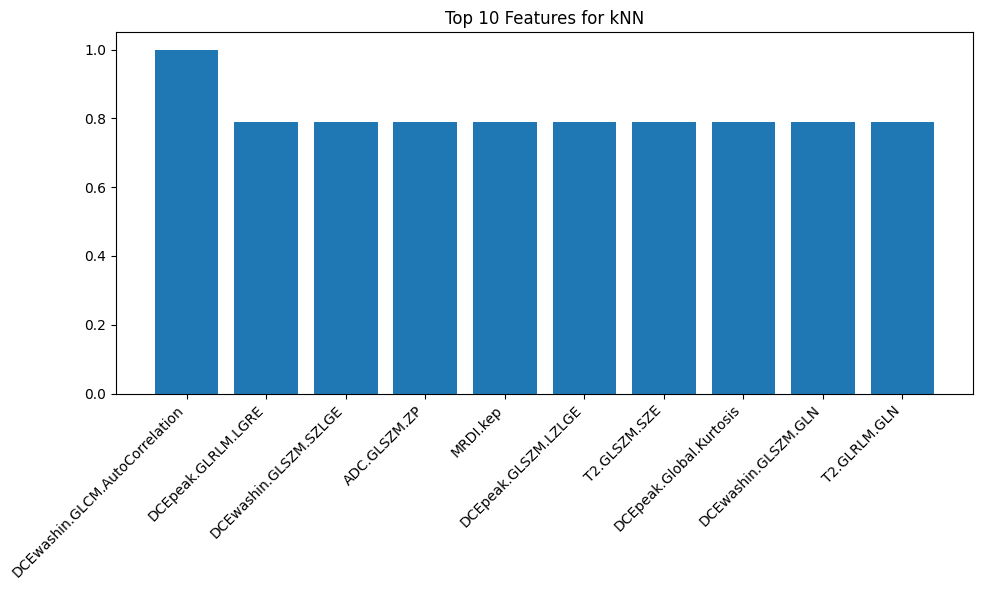

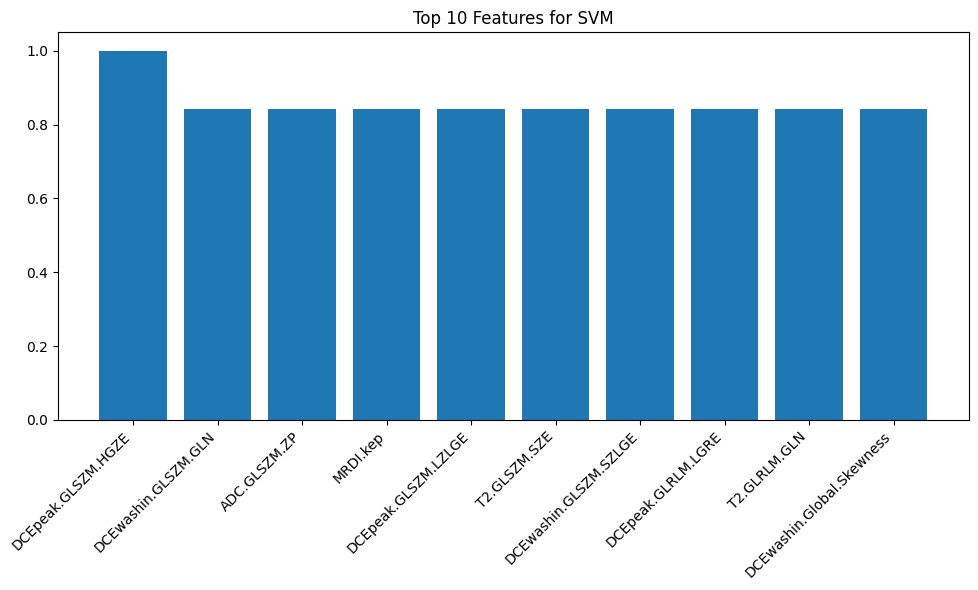

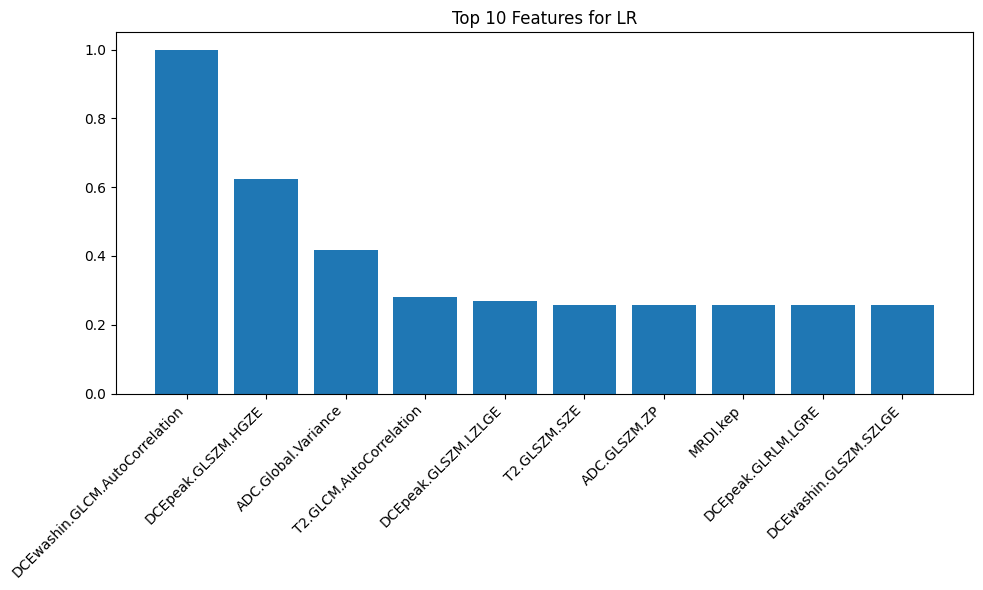

In [43]:
import matplotlib.pyplot as plt

# Normalize aggregated importance across folds
for model_name in aggregated_importance.keys():
    aggregated_importance[model_name] /= 5
    max_importance = aggregated_importance[model_name].max()
    if max_importance > 0:
        aggregated_importance[model_name] /= max_importance

# Plot the top 10 features for each model
for model_name, importance in aggregated_importance.items():
    top_features_idx = np.argsort(importance)[-10:][::-1]
    top_features = X.columns[top_features_idx]
    top_importance = importance[top_features_idx]

    plt.figure(figsize=(10, 6))
    plt.bar(top_features, top_importance)
    plt.title(f'Top 10 Features for {model_name}')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Optionally save final_results to a file
with open(r'D:\code备份\ML\86\final_results.pickle', 'wb') as f:
    pickle.dump(final_results, f)

# Save feature importance results
with open(r'D:\code备份\ML\86\aggregated_importance.pickle', 'wb') as f:
    pickle.dump(aggregated_importance, f)

[0, 14, 28, 42, 56]
[1, 15, 29, 43, 57]
[2, 16, 30, 44, 58]
[3, 17, 31, 45, 59]
[4, 18, 32, 46, 60]
[5, 19, 33, 47, 61]
[6, 20, 34, 48, 62]
[7, 21, 35, 49, 63]
[8, 22, 36, 50, 64]
[9, 23, 37, 51, 65]
[10, 24, 38, 52, 66]
[11, 25, 39, 53, 67]
[12, 26, 40, 54, 68]
[13, 27, 41, 55, 69]
[0, 14, 28, 42, 56]
[1, 15, 29, 43, 57]
[2, 16, 30, 44, 58]
[3, 17, 31, 45, 59]
[4, 18, 32, 46, 60]
[5, 19, 33, 47, 61]
[6, 20, 34, 48, 62]
[7, 21, 35, 49, 63]
[8, 22, 36, 50, 64]
[9, 23, 37, 51, 65]
[10, 24, 38, 52, 66]
[11, 25, 39, 53, 67]
[12, 26, 40, 54, 68]
[13, 27, 41, 55, 69]
[0, 14, 28, 42, 56]
[1, 15, 29, 43, 57]
[2, 16, 30, 44, 58]
[3, 17, 31, 45, 59]
[4, 18, 32, 46, 60]
[5, 19, 33, 47, 61]
[6, 20, 34, 48, 62]
[7, 21, 35, 49, 63]
[8, 22, 36, 50, 64]
[9, 23, 37, 51, 65]
[10, 24, 38, 52, 66]
[11, 25, 39, 53, 67]
[12, 26, 40, 54, 68]
[13, 27, 41, 55, 69]


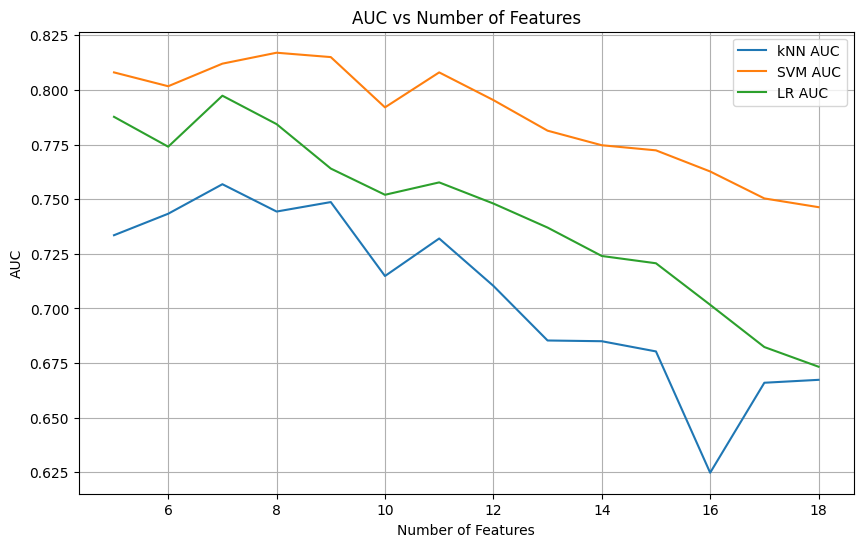

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# 示例数据结构，假设plot_data已填充
# plot_data = {
#     'LR': {'n_features': [5, 10, 15], 'mean_auc': [0.75, 0.78, 0.80], 'std_auc': [0.05, 0.04, 0.03]},
#     'kNN': {'n_features': [5, 10, 15], 'mean_auc': [0.70, 0.72, 0.74], 'std_auc': [0.06, 0.05, 0.04]},
#     'SVM': {'n_features': [5, 10, 15], 'mean_auc': [0.85, 0.87, 0.88], 'std_auc': [0.02, 0.03, 0.02]}
# }
mean_auc_values = {}
std_auc_values = {}

# 绘制曲线图
plt.figure(figsize=(10, 6))

for model_name in plot_data.keys():
    n_features = plot_data[model_name]['n_features']
    mean_auc = plot_data[model_name]['mean_auc']
    std_auc = plot_data[model_name]['std_auc']

    mean_auc_values = []
    std_auc_values = []

    for indice in range(1,15):
        indices = [(i-1) * 14 + (indice - 1) for i in range(1, 6)]
        print(indices)
        mean_auc_value = np.mean([mean_auc[idx] for idx in indices])
        std_auc_value = np.mean([std_auc[idx] for idx in indices])
        mean_auc_values.append(mean_auc_value)
        std_auc_values.append(std_auc_value)


    # # 计算平均AUC
    # mean_auc_value = np.mean(mean_auc)

    # # 打印平均AUC信息
    # print(f"Mean AUC for {model_name}: {mean_auc:.3f}")

    # 绘制曲线
    plt.plot(range(5, 19), mean_auc_values, label=f"{model_name} AUC")
    plt.fill_between(range(5, 19),
                     np.array(mean_auc_values) - np.array(std_auc_values),
                     np.array(mean_auc_values) + np.array(std_auc_values),
                     alpha=0.2)

plt.xlabel('Number of Features')
plt.ylabel('AUC')
plt.title('AUC vs Number of Features')
plt.legend()
plt.grid(True)
plt.show()

8.3 validation

In [171]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, roc_auc_score, make_scorer

# 定义选择方法
sel_method = 'rfe'

# 加载最佳模型和特征列表
with open(r'D:\code备份\ML\83_3\best_models_'+ sel_method + '.pickle', 'rb') as f:
    best_models = pickle.load(f)
with open(r'D:\code备份\ML\83_3\feat_lists_'+ sel_method + '.pickle', 'rb') as f:
    feat_list = pickle.load(f)

In [177]:
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

*************Optimizing AUC *********
%%%%% Validation of:  kNN
Selected features: 18
Performance over cross-validation:
AUC: 0.532 (0.232)
ACC: 0.610 (0.132)
bACC: 0.469 (0.127)
SENS: 0.856 (0.161)
SPEC: 0.082 (0.182)

Fold 1
Performance on testing data:
ACC: 0.571 bACC: 0.400 SENS: 0.800 SPEC: 0.000 AUC: 0.400

Fold 2
Performance on testing data:
ACC: 0.714 bACC: 0.500 SENS: 1.000 SPEC: 0.000 AUC: 0.500

Fold 3
Performance on testing data:
ACC: 0.857 bACC: 0.750 SENS: 1.000 SPEC: 0.500 AUC: 0.750

Fold 4
Performance on testing data:
ACC: 0.714 bACC: 0.500 SENS: 1.000 SPEC: 0.000 AUC: 0.500

Fold 5
Performance on testing data:
ACC: 0.286 bACC: 0.250 SENS: 0.500 SPEC: 0.000 AUC: 0.250

Fold 6
Performance on testing data:
ACC: 0.571 bACC: 0.400 SENS: 0.800 SPEC: 0.000 AUC: 0.400

Fold 7
Performance on testing data:
ACC: 0.571 bACC: 0.400 SENS: 0.800 SPEC: 0.000 AUC: 0.400

Fold 8
Performance on testing data:
ACC: 0.571 bACC: 0.400 SENS: 0.800 SPEC: 0.000 AUC: 0.400

Fold 9
Performance o

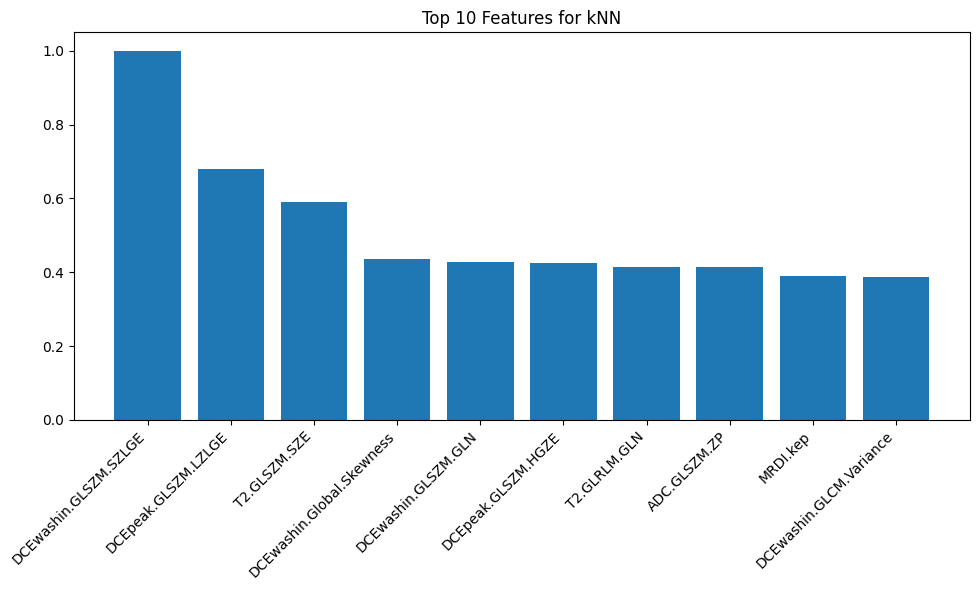

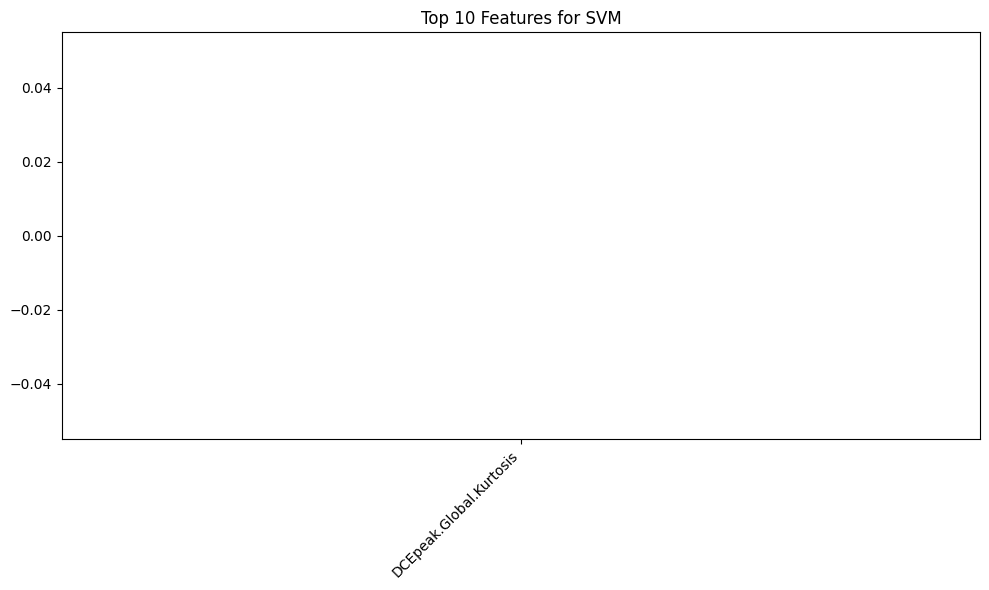

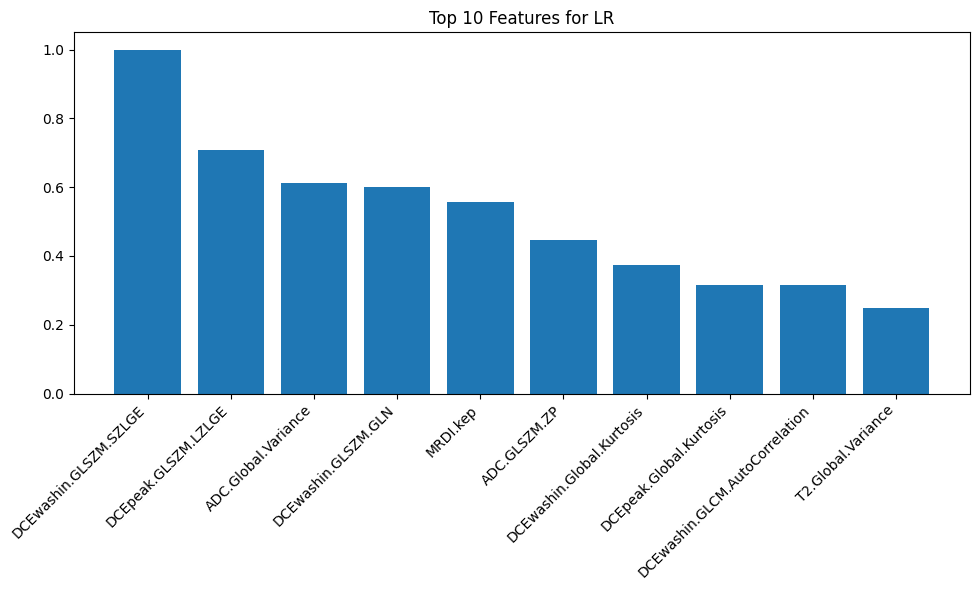

In [211]:
# 加载NKI数据集（将用于交叉验证）
df_NKI = pd.read_excel(r'D:\code备份\7.29\Hesheng Gong - code\feature_map_729.xlsx')
X_NKI = df_NKI.drop( ['Unnamed: 0','Slice no. ', 'Label', 'Patient name '], axis=1)
y_NKI = df_NKI['Label']

# 加载特征子集
f = open(r"D:\code备份\ML\Hesheng Gong\remaining_features_X.txt", "r")
f_content = f.readlines()
# selected_features = f_content.split(", ")
selected_features = [line.strip() for line in f_content if line.strip()]
selected_features = selected_features[0:-1]

# 自定义评分器
specificity = make_scorer(recall_score, pos_label=0)
multi_scorings = {"AUC": "roc_auc", "ACC": "accuracy", "bACC": 'balanced_accuracy', 
                  "SENS": "recall", "SPEC": specificity}

# 选择使用的标准化器
sc = StandardScaler()

# 定义需要优化的评估指标
metrics = ['AUC', 'bACC', 'ACC']
pfis = {}


aggregated_importance = {model_name: np.zeros(X_NKI.shape[1]) for model_name in models}


# 对每个评估指标进行优化
for mtr in metrics:
    pfis_per_model = {}
    print(f"*************Optimizing {mtr} *********")
    for mdl in best_models[mtr].keys():
        print('%%%%% Validation of: ', mdl)
        model = best_models[mtr][mdl]
        N_o = model.n_features_in_
        print(f'Selected features:', N_o)
        sel_cols = feat_list[mtr][mdl]
        X_NKI_sub = X_NKI[selected_features[0:N_o]]
        
        # 数据标准化
        X_NKI_sub = sc.fit_transform(X_NKI_sub)
        
        # 在NKI数据集上进行5折交叉验证
        cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=20, random_state=42)
        scores = cross_validate(model, X_NKI_sub, y_NKI, scoring=multi_scorings, cv=cv, n_jobs=-1)
        
        print("Performance over cross-validation:")
        for metric in multi_scorings.keys():
            print("%s: %.3f (%.3f)" % (metric, np.mean(scores['test_'+metric]), np.std(scores['test_'+metric])))



        accumulated_importance = np.zeros(X_NKI_sub.shape[1])
        num_folds = 0



        # 对每个折叠进行测试和特征重要性分析
        for fold, (train_idx, test_idx) in enumerate(cv.split(X_NKI_sub, y_NKI), start=1):
            print(f"\nFold {fold}")
            X_train, X_test = X_NKI_sub[train_idx], X_NKI_sub[test_idx]
            y_train, y_test = y_NKI.iloc[train_idx], y_NKI.iloc[test_idx]

            model.fit(X_train, y_train)
            y_predict = model.predict(X_test)

            acc = accuracy_score(y_test, y_predict)
            bacc = balanced_accuracy_score(y_test, y_predict)
            sens = recall_score(y_test, y_predict)  # 灵敏度
            spec = recall_score(y_test, y_predict, pos_label=0)  # 特异性
            auc = roc_auc_score(y_test, y_predict)

            print("Performance on testing data:")
            print("ACC: %.3f bACC: %.3f SENS: %.3f SPEC: %.3f AUC: %.3f" % (acc, bacc, sens, spec, auc))

            # 特征重要性分析
            res_pfi = pfi(model, X_test, y_test, scoring=multi_scorings[mtr], n_repeats=10, random_state=42)
            accumulated_importance += res_pfi.importances_mean
            num_folds += 1
        
        print(num_folds)

        accumulated_importance /= num_folds
        min_importance = accumulated_importance.min()
        accumulated_importance = accumulated_importance - min_importance
        accumulated_importance /= accumulated_importance.max()

        # Aggregate importance across all metrics for the model
        full_feature_importance = np.zeros(X_NKI.shape[1])
        full_feature_importance[np.isin(X_NKI.columns, sel_cols)] = accumulated_importance
        aggregated_importance[mdl] += full_feature_importance


# Normalize aggregated importance
for mdl in aggregated_importance.keys():
    aggregated_importance[mdl] /= len(metrics)
    max_importance = aggregated_importance[mdl].max()
    if max_importance > 0:
        aggregated_importance[mdl] /= max_importance

# Plot the top 10 features for each model
for mdl, importance in aggregated_importance.items():
    top_features_idx = np.argsort(importance)[-10:][::-1]
    top_features = X_NKI.columns[top_features_idx]
    top_importance = importance[top_features_idx]

    plt.figure(figsize=(10, 6))
    plt.bar(top_features, top_importance)
    plt.title(f'Top 10 Features for {mdl}')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# 保存特征重要性分析结果
with open(r'D:\code备份\ML\83_3\pfis_validation_' + sel_method + '.pickle', 'wb') as f:
    pickle.dump(pfis, f)


trySVM

*************Optimizing AUC *********
%%%%% Validation of:  SVM
Selected features: 18
Performance over cross-validation:
AUC: 0.601 (0.223)
ACC: 0.339 (0.139)
bACC: 0.510 (0.089)
SENS: 0.107 (0.256)
SPEC: 0.913 (0.203)

Fold 1
Performance on testing data:
ACC: 0.286 bACC: 0.500 SENS: 0.000 SPEC: 1.000 AUC: 0.500

Fold 2
Performance on testing data:
ACC: 0.286 bACC: 0.500 SENS: 0.000 SPEC: 1.000 AUC: 0.500

Fold 3
Performance on testing data:
ACC: 0.286 bACC: 0.500 SENS: 0.000 SPEC: 1.000 AUC: 0.500

Fold 4
Performance on testing data:
ACC: 0.286 bACC: 0.500 SENS: 0.000 SPEC: 1.000 AUC: 0.500

Fold 5
Performance on testing data:
ACC: 0.429 bACC: 0.458 SENS: 0.250 SPEC: 0.667 AUC: 0.458

Fold 6
Performance on testing data:
ACC: 0.286 bACC: 0.500 SENS: 0.000 SPEC: 1.000 AUC: 0.500

Fold 7
Performance on testing data:
ACC: 0.286 bACC: 0.500 SENS: 0.000 SPEC: 1.000 AUC: 0.500

Fold 8
Performance on testing data:
ACC: 0.286 bACC: 0.500 SENS: 0.000 SPEC: 1.000 AUC: 0.500

Fold 9
Performance o

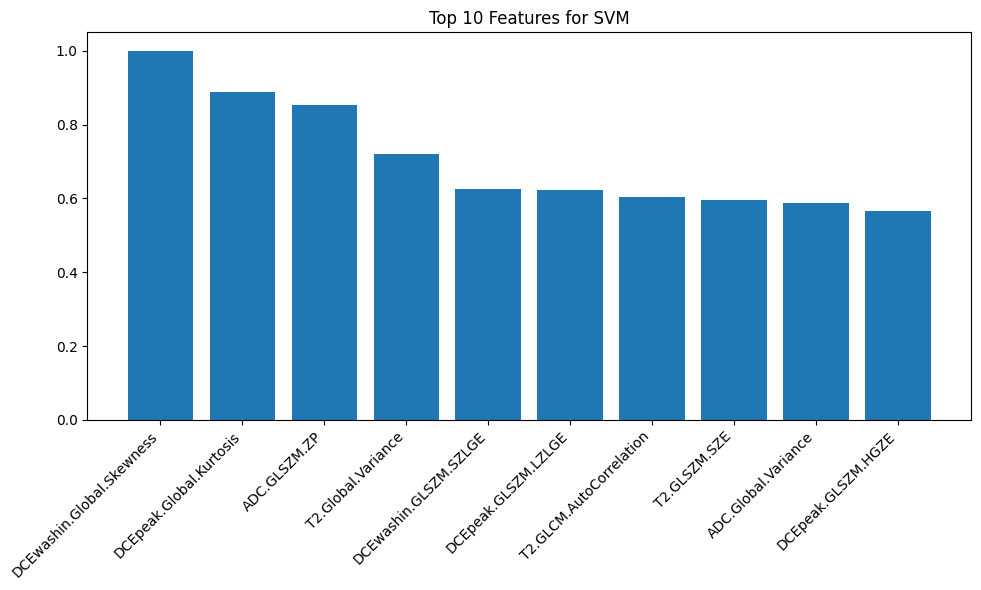

In [215]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import RepeatedStratifiedKFold, cross_validate
from sklearn.inspection import permutation_importance
from sklearn.metrics import recall_score, make_scorer, accuracy_score, balanced_accuracy_score, roc_auc_score
from sklearn.preprocessing import StandardScaler

# 自定义评分器
specificity = make_scorer(recall_score, pos_label=0)
multi_scorings = {"AUC": "roc_auc", "ACC": "accuracy", "bACC": 'balanced_accuracy', 
                  "SENS": "recall", "SPEC": specificity}

# 加载NKI数据集（将用于交叉验证）
df_NKI = pd.read_excel(r'D:\code备份\7.29\Hesheng Gong - code\feature_map_729.xlsx')
X_NKI = df_NKI.drop(['Unnamed: 0', 'Slice no. ', 'Label', 'Patient name '], axis=1)
y_NKI = df_NKI['Label']

# 加载特征子集
with open(r"D:\code备份\ML\Hesheng Gong\remaining_features_X.txt", "r") as f:
    f_content = f.readlines()
selected_features = [line.strip() for line in f_content if line.strip()]
selected_features = selected_features[0:-1]

# 选择使用的标准化器
sc = StandardScaler()

# 定义需要优化的评估指标
metrics = ['AUC', 'bACC', 'ACC']

# Initialize aggregated_importance
aggregated_importance = {model_name: np.zeros(X_NKI.shape[1]) for model_name in ['SVM']}

# 对每个评估指标进行优化
for mtr in metrics:
    print(f"*************Optimizing {mtr} *********")
    for mdl in best_models[mtr].keys():
        if mdl != 'SVM':
            continue  # 仅处理SVM模型

        print('%%%%% Validation of: ', mdl)
        model = best_models[mtr][mdl]
        N_o = model.n_features_in_
        print(f'Selected features:', N_o)

        # 使用选择的特征
        sel_cols = feat_list[mtr][mdl]
        X_NKI_sub = X_NKI[sel_cols]
        
        # 数据标准化
        X_NKI_sub = sc.fit_transform(X_NKI_sub)
        
        # 在NKI数据集上进行5折交叉验证
        cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=20, random_state=42)
        scores = cross_validate(model, X_NKI_sub, y_NKI, scoring=multi_scorings, cv=cv, n_jobs=-1)
        
        print("Performance over cross-validation:")
        for metric in multi_scorings.keys():
            print("%s: %.3f (%.3f)" % (metric, np.mean(scores['test_' + metric]), np.std(scores['test_' + metric])))

        accumulated_importance = np.zeros(X_NKI_sub.shape[1])
        num_folds = 0

        # 对每个折叠进行测试和特征重要性分析
        for fold, (train_idx, test_idx) in enumerate(cv.split(X_NKI_sub, y_NKI), start=1):
            print(f"\nFold {fold}")
            X_train, X_test = X_NKI_sub[train_idx], X_NKI_sub[test_idx]
            y_train, y_test = y_NKI.iloc[train_idx], y_NKI.iloc[test_idx]

            model.fit(X_train, y_train)
            y_predict = model.predict(X_test)

            acc = accuracy_score(y_test, y_predict)
            bacc = balanced_accuracy_score(y_test, y_predict)
            sens = recall_score(y_test, y_predict)  # 灵敏度
            spec = recall_score(y_test, y_predict, pos_label=0)  # 特异性
            auc = roc_auc_score(y_test, y_predict)

            print("Performance on testing data:")
            print("ACC: %.3f bACC: %.3f SENS: %.3f SPEC: %.3f AUC: %.3f" % (acc, bacc, sens, spec, auc))

            # 特征重要性分析
            res_pfi = permutation_importance(model, X_test, y_test, scoring=multi_scorings[mtr], n_repeats=10, random_state=42)
            accumulated_importance += res_pfi.importances_mean
            num_folds += 1

        accumulated_importance /= num_folds
        min_importance = accumulated_importance.min()
        accumulated_importance = accumulated_importance - min_importance
        if accumulated_importance.max() > 0:
            accumulated_importance /= accumulated_importance.max()

        # 聚合重要性到总体中
        full_feature_importance = np.zeros(X_NKI.shape[1])
        full_feature_importance[np.isin(X_NKI.columns, sel_cols)] = accumulated_importance
        aggregated_importance[mdl] += full_feature_importance

# 归一化聚合重要性
for mdl in aggregated_importance.keys():
    aggregated_importance[mdl] /= len(metrics)
    max_importance = aggregated_importance[mdl].max()
    if max_importance > 0:
        aggregated_importance[mdl] /= max_importance

# 绘制每个模型的前10个特征
for mdl, importance in aggregated_importance.items():
    top_features_idx = np.argsort(importance)[-10:][::-1]
    top_features = X_NKI.columns[top_features_idx]
    top_importance = importance[top_features_idx]

    plt.figure(figsize=(10, 6))
    plt.bar(top_features, top_importance)
    plt.title(f'Top 10 Features for {mdl}')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# 保存特征重要性分析结果
with open(r'D:\code备份\ML\83_3\pfis_SVM_validation_' + sel_method + '.pickle', 'wb') as f:
    pickle.dump(aggregated_importance, f)


In [43]:
# multi_scorings = {
#     "AUC": roc_auc_score,
#     "ACC": accuracy_score,
#     "bACC": balanced_accuracy_score,
#     "SENS": recall_score,
#     "SPEC": make_scorer(specificity_score)
# }

# final_model_performance = []
# for model_name in models:
#     print(f"Training final model for {model_name}")
#     if model_name == "LR":
#         final_model = LogisticRegression(class_weight='balanced')
#     elif model_name == "kNN":
#         final_model = LogisticRegression()
#     elif model_name == "SVM":
#         final_model = LogisticRegression(class_weight='balanced')

#     final_model.fit(X[sorted_features], y)

#     for train_idx, test_idx in cv_outer.split(X, y, groups):
#         X_test = X.iloc[test_idx]
#         y_test = y[test_idx]
#         y_pred = final_model.predict(X_test[sorted_features])

#         performance = {}
#         for metric in scoring_metrics:
#             if metric == 'SPEC':
#                 # 对于特异性评分，使用 _score_func
#                 performance[metric] = multi_scorings[metric]._score_func(y_test, y_pred)
#             else:
#                 performance[metric] = multi_scorings[metric](y_test, y_pred)

#         # performance = {metric: multi_scorings[metric](y_test, y_pred) for metric in scoring_metrics}
#         final_model_performance.append((model_name, performance))

# # 保存最终的比较结果
# final_comparison_df = pd.DataFrame(final_model_performance, columns=["Model", "Performance"])
# final_comparison_df.to_csv(r'D:\code备份\ML\81\final_model_comparison_2.csv')

# print("Final comparison results saved.")

Training final model for kNN
Training final model for SVM
Training final model for LR
Final comparison results saved.
